In [ ]:
%load_ext autoreload
%autoreload 2


from liftout.structures import Sample, load_experiment


import os 
import numpy as np
import matplotlib.pyplot as plt



In [ ]:
# path = r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-05_2022-08-29.11-57-03AM" # 6
path = r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-06_2022-08-30.03-26-27PM" # 3

sample = load_experiment(path)
sample.__to_dataframe__()

### Log Parsing (new)

In [ ]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from copy import deepcopy
from dataclasses import dataclass

from pathlib import Path

from liftout.tools.data import calculate_statistics_dataframe, AutoLiftoutStatistics, calculate_aggregated_statistics


paths = [
    r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-05_2022-08-29.11-57-03AM",
    r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-06_2022-08-30.03-26-27PM"
]





In [ ]:
df = calculate_aggregated_statistics(paths)
display(df)

In [ ]:
# specimen current
microscope.state.specimen_current.value

## System Settings
Set / Restore system settings


In [ ]:
%load_ext autoreload
%autoreload 2
from fibsem import utils, calibration
from fibsem.structures import BeamSystemSettings, SystemSettings, BeamType

from autoscript_sdb_microscope_client import SdbMicroscopeClient

from pprint import pprint 

In [ ]:
microscope, settings = utils.setup_session()

In [ ]:
eb_settings = calibration.get_current_beam_system_state(microscope, BeamType.ELECTRON)
ib_settings = calibration.get_current_beam_system_state(microscope, BeamType.ION)
pprint(eb_settings)
pprint(ib_settings)

In [ ]:
from dataclasses import asdict
# check if settings are different
for i, (a, b) in enumerate(list(zip(asdict(eb_settings).values(), asdict(settings.system.electron).values()))):

    if a != b:
        k = list(asdict(eb_settings).keys())[i]
        print("not equal: ", k, a, b)

## History Bug

In [ ]:
%load_ext autoreload
%autoreload 2

from liftout.structures import create_experiment, Lamella, AutoLiftoutStage
from liftout.autoliftout import update_sample_lamella_data
from fibsem import utils
from pprint import pprint
from liftout import autoliftout


microscope, settings = utils.setup_session()
os.makedirs("test", exist_ok=True)
sample = create_experiment("test-history", "test")


In [ ]:
lamella = Lamella(sample.path, 1)
sample = update_sample_lamella_data(sample, lamella)

stages = [stage for stage in AutoLiftoutStage][2:]

for stage in stages:
    print(stage)
    pprint(sample)
    pprint(sample.positions[1])

    lamella.current_state.stage = stage
    sample = autoliftout.end_of_stage_update(microscope, sample, lamella, )
    
    pprint(sample)
    pprint(sample.positions[1])
    pprint([state.stage.name for state in sample.positions[1].history])
    print("-"*50)

## Initial Calibration

Set the initial grid states 

set the initial calibration (eucentric, horizontal shift, needle)

## New AutoLiftout UI

autoliftout ui in napari


In [80]:
%load_ext autoreload
%autoreload 2

from liftout.structures import load_experiment, Sample
from autoscript_sdb_microscope_client.structures import AdornedImage
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import napari


pprint(sample)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Sample: 
        Path: c:\users\admin\github\autoliftout\liftout\log\dm-embryo-05_2022-08-29.11-57-03AM
        State: None
        Lamella: 5
        


In [81]:
DISPLAY_REFERENCE_FNAMES = [
    "ref_lamella_low_res_ib",
    "ref_trench_high_res_ib",
    "ref_jcut_high_res_ib",
    "ref_liftout_ib",
    "ref_landing_lamella_high_res_ib",
    "ref_reset_high_res_ib",
    "ref_thin_lamella_post_superres_ib",
    "ref_polish_lamella_post_superres_ib",
]

headers = [
    "Sample No",
    "Position",
    "Reference",
    "Milling",
    "J-Cut",
    "Liftout",
    "Landing",
    "Reset",
    "Thinning",
    "Polishing",
]

In [82]:

def create_overview_image(sample: Sample) -> np.ndarray:

    PAD_PX = 20
    BASE_SHAPE = None

    vstack = None
    for i, lamella in enumerate(sample.positions.values()):

        hstack = None
        for fname in DISPLAY_REFERENCE_FNAMES:
            
            path = os.path.join(lamella.path, f"{fname}.tif")

            if os.path.exists(path):
                image = lamella.load_reference_image(fname)
            else:
                image = data=np.zeros(shape=BASE_SHAPE)

            if BASE_SHAPE is None:
                BASE_SHAPE = image.data.shape

            image = np.pad(image.data, pad_width=PAD_PX)


            if hstack is None:
                hstack = image
            else:
                hstack = np.hstack([hstack, image])


        hstack = np.pad(hstack, pad_width=PAD_PX)
        if vstack is None:
            vstack = hstack
        else:
            vstack = np.vstack([vstack, hstack])
        
    vstack = vstack.astype(np.uint8)
    overview_image = ndi.median_filter(vstack, size=3)

    return overview_image


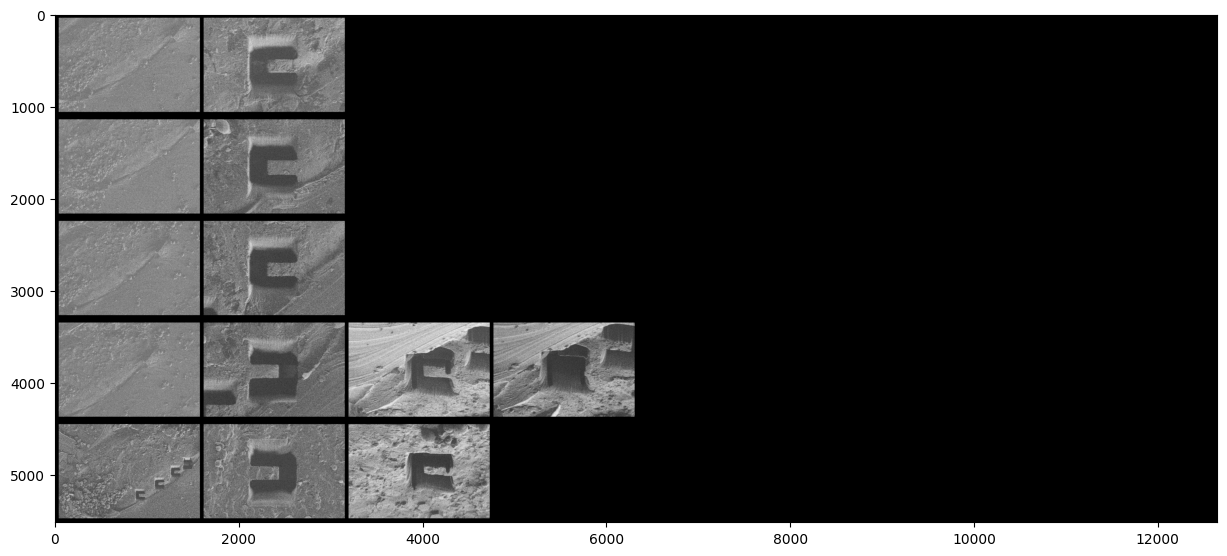

In [78]:
plt.figure(figsize=(15, 15))
plt.imshow(overview_image, cmap="gray")
plt.show()

In [84]:
# path = r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-05_2022-08-29.11-57-03AM" # 6
path = r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-06_2022-08-30.03-26-27PM" # 3

sample = load_experiment(path)


overview_image = create_overview_image(sample)
viewer = napari.Viewer()
viewer.add_image(overview_image, name="AutoLiftout")

<Image layer 'AutoLiftout' at 0x2633993c2e0>